# LA County Board of Supervisors - 2nd District Maps

These maps visualize campaign donations made this campaign cycle to the three candidates running to replace Mark Ridley-Thomas on the Board of Supervisors, L.A. County's governing body. 

In [1]:
"""
A Los Angeles Times theme for Altair.
"""
# Color schemes and defaults
palette = dict(
    black='#000000',
    white='#ffffff',
    default='#82c6df',
    accent='#006d8f',
    highlight='#ec8431',
    democrat='#5789b8',
    republican='#d94f54',
    schemes={
    
    'brewer': [
        '#66c2a5',
        '#fc8d62',
        '#8da0cb',
        '#e78ac3',
        '#a6d854',
        '#ffd92f',
        '#e5c494'
    ],
    'category-6': [
        '#3580b1',
        '#ec8431',
        '#ab7fb4',
        '#c89d29',
        '#adc839',
        '#829eb1',
    ],
      'fire-7': [
        '#fbf2c7',
        '#f9e39c',
        '#f8d36e',
        '#f4bb6a',
        '#e68a4f',
        '#d15a40',
        '#ab4232',
    ],
    'fireandice-6': [
        '#e68a4f',
        '#f4bb6a',
        '#f9e39c',
        '#dadfe2',
        '#a6b7c6',
        '#849eae',
    ],
    'ice-7': [
        '#edefee',
        '#dadfe2',
        '#c4ccd2',
        '#a6b7c6',
        '#849eae',
        '#607785',
        '#47525d',
    ],
    }
)


def stiles():
    """
    A Los Angeles Times theme for Altair.
    """
    # Headline stuff
    headlineFontSize = 22
    headlineFontWeight = "normal"
    headlineFont = 'Benton Gothic Bold, sans'

    # Titles for axes and legends and such
    titleFont = 'Benton Gothic Bold, sans'
    titleFontWeight = 'normal'
    titleFontSize = 14

    # Labels for ticks and legend entries and such
    labelFont = 'Benton Gothic, sans'
    labelFontSize = 12
    labelFontWeight = 'bold'

    return dict(
        config=dict(
            view=dict(
                width=800,
                height=450
            ),
            background=palette['white'],
            title=dict(
                anchor='start',
                font=headlineFont,
                fontColor=palette['black'],
                fontSize=headlineFontSize,
                fontWeight=headlineFontWeight,
                Y=-5
            ),
            arc=dict(fill=palette['default']),
            area=dict(fill=palette['default']),
            line=dict(stroke=palette['default'], strokeWidth=3),
            path=dict(stroke=palette['default']),
            rect=dict(fill=palette['default']),
            shape=dict(stroke=palette['default']),
            bar=dict(fill=palette['default']),
            point=dict(stroke=palette['default']),
            symbol=dict(fill=palette['default'], size=30),
            axis=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                titleFontWeight=titleFontWeight,
                labelFont=labelFont,
                labelFontSize=labelFontSize,
                labelFontWeight=labelFontWeight
            ),
            axisX=dict(
                labelAngle=0,
                labelPadding=4,
                tickSize=3
            ),
            axisY=dict(
                labelBaseline='middle',
                maxExtent=45,
                minExtent=45,
                tickSize=2,
                titleAlign='left',
                titleAngle=0,
                titleX=-45,
                titleY=-5
            ),
            legend=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                symbolType='square',
                labelFont=labelFont,
                labelFontSize=labelFontSize + 1,
                labelFontWeight = 'bold'
            ),
            range=dict(
                category=palette['schemes']['category-6'],
                diverging=palette['schemes']['fireandice-6'],
                heatmap=palette['schemes']['fire-7'],
                ordinal=palette['schemes']['fire-7'],
                ramp=palette['schemes']['fire-7']
            )
        )
    )

In [2]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas as gpd
import descartes
import geojson
import scheme
import mapclassify
import json
import pysal as ps
import jenkspy
import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
# alt.themes.register('latimes', lat.theme)
# alt.themes.enable('latimes')

# register the custom theme under a chosen name
alt.themes.register('stiles', stiles)
# enable the newly registered theme
alt.themes.enable('stiles')


/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


ThemeRegistry.enable('stiles')

### Get the data from our larger donations database of committees in all countywide races back to 2007. 

In [3]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [4]:
alldonations =  psql.read_sql("SELECT * FROM contributions", database_con)

### Let's clean up the spaces and capitalization in field names

In [5]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [6]:
alldonations.head(2)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,employer,int_name,int_city,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500.0,...,,,,,,,,,2557,164858
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,Other,2018-12-31,1500.0,...,,,,,,,,,2557,164916


### Some date parsing

In [7]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [8]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = pd.to_datetime(alldonations['date']).map(lambda dt: dt.replace(day=1))
alldonations['candidate'] = alldonations['first_name'] + ' ' + alldonations['last_name']
alldonations['candidate'] = alldonations['candidate'].str.title()
alldonations['candidate'] = alldonations['candidate'].str.replace("Holly J. Mitchell", "Holly Mitchell")
alldonations['type'] = alldonations['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
alldonations['last_name'] = alldonations['last_name'].str.upper()
alldonations['committee_name'] = alldonations['committee_name'].str.upper()
alldonations['first_name'] = alldonations['first_name'].str.upper()
alldonations['months'] = alldonations['date'].dt.strftime('%m/%Y').astype(str)


In [9]:
alldonations

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_occupation,int_employer,doc_id,rec_id,x,year,month,monthyear,candidate,months
0,BARGER,KATHRYN,1414462,KATHRYN BARGER FOR SUPERVISOR 2020,CSU,C05,A,Other,2018-12-31,1500,...,,,,2557,164858,2018,12,2018-12-01,Kathryn Barger,12/2018
1,BARGER,KATHRYN,1414462,KATHRYN BARGER FOR SUPERVISOR 2020,CSU,C05,A,Other,2018-12-31,1500,...,,,,2557,164916,2018,12,2018-12-01,Kathryn Barger,12/2018
2,NAJARIAN,ARA JAMES,1376291,NAJARIAN FOR LOS ANGELES COUNTY SUPERVISOR 2016,CSU,C05,A,Other,2016-04-22,1500,...,,,,2302,154849,2016,4,2016-04-01,Ara James Najarian,04/2016
3,LACEY,JACQUELYN,1334856,COMMITTEE TO ELECT JACKIE LACEY FOR DA 2012,DAT,N/A,A,Other,2012-10-04,1000,...,,,,1630,88438,2012,10,2012-10-01,Jacquelyn Lacey,10/2012
4,WESSON,HERB,1414475,WESSON FOR SUPERVISOR 2020,CSU,C02,A,Other,2019-04-29,1500,...,,,,2581,167892,2019,4,2019-04-01,Herb Wesson,04/2019
5,BARGER,KATHRYN,1376396,KATHRYN BARGER FOR SUPERVISOR 2016,CSU,C05,A,Other,2016-09-30,1500,...,,,,2306,155502,2016,9,2016-09-01,Kathryn Barger,09/2016
6,BARGER,KATHRYN,1376396,KATHRYN BARGER FOR SUPERVISOR 2016,CSU,C05,A,Other,2016-09-30,1500,...,,,,2306,155614,2016,9,2016-09-01,Kathryn Barger,09/2016
7,BARGER,KATHRYN,1376396,KATHRYN BARGER FOR SUPERVISOR 2016,CSU,C05,A,Other,2016-09-30,1500,...,,,,2306,155695,2016,9,2016-09-01,Kathryn Barger,09/2016
8,SOLIS,HILDA,1374016,SOLIS FOR SUPERVISOR 2014 OFFICEHOLDER ACCOUNT,CSU,N/A,A,Other,2016-09-30,500,...,,,,2313,155778,2016,9,2016-09-01,Hilda Solis,09/2016
9,BARGER,KATHRYN,1376396,KATHRYN BARGER FOR SUPERVISOR 2016,CSU,C05,A,Other,2016-09-29,500,...,,,,2306,155733,2016,9,2016-09-01,Kathryn Barger,09/2016


In [10]:
alldonations.groupby(['contributor_zip_code', 'committee_name' 'year', 'type']).sum().reset_index().sort_values(['amount_rcvd'], ascending=[False])

,contributor_zip_code,year,type,amount_rcvd,amount_pd
4646,90288,2016,Individual,2825030,0.00
2389,90010,2014,Individual,1030855,0.00
3939,90210,2014,Individual,387285,0.00
3435,90049,2014,Individual,320902,0.00
3941,90210,2015,Individual,201188,0.00
4854,90402,2014,Individual,197805,0.00
3757,90069,2014,Individual,195034,0.00
6638,91108,2015,Individual,188600,0.00
4486,90266,2016,Individual,176850,0.00
3993,90212,2014,Individual,175650,0.00


### Filter out older contributions.

In [11]:
nudonations = alldonations[alldonations.date > '2018-06-30']

### Aggregate by month/year to make sure we filter appropriately. 

In [12]:
nudonations[['date', 'amount_rcvd']].groupby(nudonations.date.dt.to_period("M")).agg(['sum', 'size', 'mean'])

amount_rcvd                   
                sum  size         mean
date                                  
2018-07       87659   150   584.393333
2018-08      232188   323   718.848297
2018-09      304368   473   643.484144
2018-10      609077   803   758.501868
2018-11      176696   207   853.603865
2018-12      859396   700  1227.708571
2019-01      179180   187   958.181818
2019-02      607890   697   872.152080
2019-03      479805   509   942.642436
2019-04      419783   563   745.618117
2019-05      545495   706   772.655807
2019-06     1003559  1398   717.853362

## Three stories: Group 2020 contributions data by 1) race, 2) time, 3) zip code.

### Select only donations to candidates running in District 2

In [13]:
thiscycle = nudonations[(nudonations['date'] > '2018-06-30')]
district_two_candidates = (['PERRY','WESSON','MITCHELL','JEONG'])
thiscycle = thiscycle[thiscycle['last_name'].isin(district_two_candidates)]

In [14]:
thiscycle.groupby('candidate').agg(['sum', 'size', 'mean'])


amount_rcvd                   amount_pd          
                       sum size         mean       sum size mean
candidate                                                       
Chan Jeong           46100   82   562.195122       0.0   82  0.0
Herb Wesson        1119445  960  1166.088542       0.0  960  0.0
Holly Mitchell      564594  767   736.106910       0.0  767  0.0
Jan Perry           509760  893   570.839866       0.0  893  0.0

In [36]:
thiscycle.groupby(['contributor_zip_code', 'candidate']).agg(['sum', 'size', 'mean'])

amount_rcvd              amount_pd       \
                                            sum size    mean       sum size   
contributor_zip_code candidate                                                
10004                Holly Mitchell         250    1   250.0       0.0    1   
10010                Holly Mitchell        1000    1  1000.0       0.0    1   
10011                Holly Mitchell        1500    1  1500.0       0.0    1   
10014                Herb Wesson           1500    1  1500.0       0.0    1   
10017                Herb Wesson           1500    1  1500.0       0.0    1   
...                                         ...  ...     ...       ...  ...   
98004                Holly Mitchell        1500    1  1500.0       0.0    1   
98006                Holly Mitchell        1000    1  1000.0       0.0    1   
98104                Holly Mitchell        1500    2   750.0       0.0    2   
98134                Jan Perry             1500    2   750.0       0.0    2   
98664                Jan Perry              200    1   200.0       0.0    1   

                                          
                                    mean  
contributor_zip_code candidate            
10004                Holly Mitchell  0.0  
10010                Holly Mitchell  0.0  
10011                Holly Mitchell  0.0  
10014                Herb Wesson     0.0  
10017                Herb Wesson     0.0  
...                                  ...  
98004                Holly Mitchell  0.0  
98006                Holly Mitchell  0.0  
98104                Holly Mitchell  0.0  
98134                Jan Perry       0.0  
98664                Jan Perry       0.0  

[885 rows x 6 columns]

In [15]:
thiscycle.head(3)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_occupation,int_employer,doc_id,rec_id,x,year,month,monthyear,candidate,months
4,WESSON,HERB,1414475,WESSON FOR SUPERVISOR 2020,CSU,C02,A,Other,2019-04-29,1500,...,,,,2581,167892,2019,4,2019-04-01,Herb Wesson,04/2019
71,WESSON,HERB,1414475,WESSON FOR SUPERVISOR 2020,CSU,N/A,A,Committee,2018-12-31,1500,...,,,,2546,164456,2018,12,2018-12-01,Herb Wesson,12/2018
72,WESSON,HERB,1414475,WESSON FOR SUPERVISOR 2020,CSU,N/A,A,Committee,2018-12-31,1500,...,,,,2546,164634,2018,12,2018-12-01,Herb Wesson,12/2018


In [16]:
thiscycletrim = thiscycle[[
    'last_name',
    'first_name',
    'candidate',
    'committee_id',
    'committee_name',
    'office_type',
    'district_number',
    'schedule',
    'type',
    'date',
    'amount_rcvd',
    'description',
    'contributor_first_name',
    'contributor_last_name',
    'contributor_address',
    'contributor_city',
    'contributor_state',
    'contributor_zip_code',
    'occupation',
    'employer',
    'doc_id',
    'rec_id',
    'year',
    'month',
    'months'
]]

In [28]:
thiscycletrim['contributor_address']

4         
71        
72        
113       
114       
        ..
76301     
76302     
76303     
76304     
77431     
Name: contributor_address, Length: 2702, dtype: object

# EXPORT FOR 'THISCYCLE' TABLE

In [27]:
thiscycletrim.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycle.csv", index=False)
addresses.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/addresses.csv", index=False)

NameError: name 'addresses' is not defined

***

### 1) Create a dataframe with summary stats for each campaign this cycle

In [ ]:
thiscycletotals = thiscycle.groupby(['candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

### 1) Clean up the hierarchical column structure. Standardize names in all caps.

In [ ]:
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].astype(int)
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round()
thiscycletotals

# EXPORT FOR 'THISCYCLETOTALS' TABLE

In [ ]:
thiscycletotals.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycletotals.csv", index=False)

***

## 2) When were the donations given during the time period?

In [ ]:
thiscycletime = thiscycle.groupby(['monthyear','year','month', 'candidate'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [ ]:
thiscycletime
flat_columns = [''.join(t) for t in thiscycletime.columns]
thiscycletime.columns = flat_columns
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].astype(int)
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].round()
thiscycletime.head(10)
thiscycletime['months'] = thiscycletime['monthyear'].dt.strftime('%m/%d/%Y').astype(str)
thiscycletime

## Which zip codes are in LA County?

### Read in a list extracted from a spatial file

In [ ]:
la_zipcodes = pd.read_csv('/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/lazips_grouped.csv')

In [ ]:
la_zips_list = la_zipcodes['zip_code'].to_csv(header=False, index=False).strip('\n').split('\n')

In [ ]:
thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]
thiscycle_la_zips = thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]

In [ ]:
thiscycletrim['lacounty'] = np.where(thiscycletrim['contributor_zip_code'].isin(la_zips_list), 'Inside LA County', 'Outside LA County')

## Which zip codes are most common?

### Filter for zip codes inside and outside the county

In [ ]:
in_la = thiscycletrim[thiscycletrim.lacounty.isin(['Inside LA County'])]
out_la = thiscycletrim[thiscycletrim.lacounty.isin(['Outside LA County'])]

### Donation TOTALS for zips inside and outside the county, by zip

In [ ]:
#zip sum totals w/o candidates — in LA
sum_inla_zips = in_la.groupby(['contributor_zip_code'])['amount_rcvd'].agg('sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/o candidates — outside LA
sum_outla_zips = out_la.groupby(["contributor_zip_code"])['amount_rcvd'].agg( 'sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/ candidates — in LA
cand_sum_inla_zips = in_la.groupby(['contributor_zip_code', 'candidate'])['amount_rcvd'].agg('sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

#zip sum totals w/ candidates — out LA
cand_sum_outla_zips = out_la.groupby(["contributor_zip_code",'candidate'])['amount_rcvd'].agg( 'sum').reset_index().sort_values(['amount_rcvd','contributor_zip_code',],ascending=False).set_index(['contributor_zip_code'])

### Donation COUNTS for zips inside and outside the county, by zip

In [ ]:
#zip counts w/o candidates — in LA
size_inla_zips = in_la.groupby(['contributor_zip_code']).agg('size').to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/o candidates — out LA
size_outla_zips = out_la.groupby(['contributor_zip_code']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/ candidates — in LA
cand_size_inla_zips = in_la.groupby(['contributor_zip_code', 'candidate']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

#zip counts w/ candidates — out LA
cand_size_outla_zips = out_la.groupby(['contributor_zip_code', 'candidate']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

In [ ]:
cand_sum_inla_zips.head(10)

### Which 10 LA zip codes gave the most? 

In [1]:
sum_inla_zips.head(10)

NameError: name 'sum_inla_zips' is not defined

### Which 10 outside LA zip codes gave the most? 

In [ ]:
sum_outla_zips.head(10)

### Flatten column names in LA zip code sum dataframe

In [ ]:
#Aggregate totals
sum_inla_zips = pd.DataFrame(sum_inla_zips.to_records(), columns=sum_inla_zips.index.names + list(sum_inla_zips.columns))

#Candidate specific totals by zip
cand_sum_inla_zips = pd.DataFrame(cand_sum_inla_zips.to_records(), columns=cand_sum_inla_zips.index.names + list(cand_sum_inla_zips.columns))

In [ ]:
cand_sum_inla_zips.head(3)
sum_inla_zips.head(3)

***

# MAPS!


### Load our spatial data

In [21]:
#CA zip codes
calizipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/californiazips_simple.json")

#CA state boundary
calimap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/california.shp")

#LA County zip codes
lazipsmap = gpd.read_file("/Users/mhustiles/Desktop/data/GIS/LA/la_county_gis_zipcodes/la_county_zipcodes_dissolved.geojson")

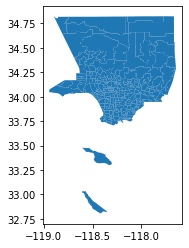

In [22]:
lazipsmap.plot()

In [24]:
calizipsmap.dtypes

ZCTA5CE10     object
INTPTLAT10    object
INTPTLON10    object
geometry      object
dtype: object

### Clean up field names

In [25]:
lazipsmaptrim = lazipsmap[[
    'ZIPCODE',
    'geometry'
]].rename(columns={
    'ZIPCODE': "zip_code",
    'geometry': "geometry",
})

calizipsmaptrim = calizipsmap[[
    'ZCTA5CE10',
    'INTPTLAT10',
    'INTPTLON10',
    'geometry'
]].rename(columns={
    'ZCTA5CE10': 'zip_code',
    'INTPTLAT10': 'lat',
    'INTPTLON10': 'lon',
    'geometry': 'geometry'
})

In [26]:
calizipsmaptrim.dtypes

zip_code    object
lat         object
lon         object
geometry    object
dtype: object

### Get rid of the islands

In [ ]:
clean_la_zip_map = lazipsmaptrim[lazipsmaptrim.zip_code != '90704']

In [ ]:
clean_la_zip_map.plot()

## Merge all donations by zip with zip code boundaries

In [ ]:
merged_all_cands_la_zips = clean_la_zip_map.merge(
    sum_inla_zips[['contributor_zip_code', "amount_rcvd"]],
    left_on="zip_code",
    right_on="contributor_zip_code"
)

In [ ]:
merged_all_cands_ca_zips = calizipsmaptrim

 = clean_la_zip_map.merge(
    sum_inla_zips[['contributor_zip_code', "amount_rcvd"]],
    left_on="zip_code",
    right_on="contributor_zip_code"
)

In [ ]:
merged_all_cands_la_zips.sort_values(['amount_rcvd'], ascending=[False]).head(10)

In [ ]:
merged_all_cands_la_zips.plot()

In [ ]:
alt.data_transformers.enable('json')

In [ ]:
%matplotlib inline

### Get natural breaks for candidate zip totals

In [ ]:
breaks = jenkspy.jenks_breaks((merged_all_cands_la_zips.amount_rcvd), nb_class=7)

In [ ]:
breaks

### Set the breaks in a categorical field

In [ ]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [ ]:
merged_all_cands_la_zips['amount_group'] = merged_all_cands_la_zips.amount_rcvd.apply(get_group)

### Dump that spatial data for testing in QGIS

In [ ]:
merged_all_cands_la_zips.to_file("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/merged_all_cands_la_zips.geojson", driver="GeoJSON")

### Prep spatial data for Altair

In [ ]:
geojson = json.loads(merged_all_cands_la_zips.to_json())
features = alt.Data(values=geojson['features'])

In [ ]:
base = alt.Chart(features).mark_geoshape(
    stroke='white',
    strokeWidth=0.4
).encode().properties(
    width=600,
    height=800
)

In [ ]:
geoshape = alt.Chart(features).mark_geoshape(
    fill='#e6e6e6',
    stroke='white'
)

In [ ]:
totals = geoshape.encode(
    color=alt.Color(
        "properties.amount_group:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    )
)

In [ ]:
(base + totals).properties(title="Totals by zip").configure_view(
    strokeWidth=0
)

In [ ]:
alt.Chart(features).mark_geoshape().encode(
    color='properties.amount_group:N'
).transform_lookup(
    lookup='zip_code',
    from_=alt.LookupData(features, 'zip_code', ['properties.amount_group:N'])
).properties(
    width=500,
    height=300
)